# Open CTD and SSH altimetry data

SSH data downloaded from: https://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_MY_008_047/description
- 31/12/1992–01/08/2025<br>
- The sea level anomaly is the sea surface height above mean sea surface; it is referenced to the [1993, 2012] period

Use bash script `download_cmems_ssh_yearly_netcdfs.sh` to download subset of files into yearly netcdfs

In situ CTD profiles downloaded from:
https://cchdo.ucsd.edu/search?q=woce_line:%22AR07W%22

In [6]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
import pyproj

In [7]:
ssh_1993 = xr.open_dataset('/Users/mzahn/data/SSH/cmems_ssh_yearly/ssh_cmems_l4_0pt125deg_50N_65N_60W_40W_1993.nc')
ssh_2024 = xr.open_dataset('/Users/mzahn/data/SSH/cmems_ssh_yearly/ssh_cmems_l4_0pt125deg_50N_65N_60W_40W_2024.nc')

In [9]:
ssh_1993

<xarray.Dataset> Size: 561MB
Dimensions:         (time: 365, latitude: 120, longitude: 160)
Coordinates:
  * latitude        (latitude) float32 480B 50.06 50.19 50.31 ... 64.81 64.94
  * longitude       (longitude) float32 640B -59.94 -59.81 ... -40.19 -40.06
  * time            (time) datetime64[ns] 3kB 1993-01-01 ... 1993-12-31
Data variables:
    adt             (time, latitude, longitude) float64 56MB ...
    err_sla         (time, latitude, longitude) float64 56MB ...
    err_ugosa       (time, latitude, longitude) float64 56MB ...
    err_vgosa       (time, latitude, longitude) float64 56MB ...
    flag_ice        (time, latitude, longitude) float64 56MB ...
    sla             (time, latitude, longitude) float64 56MB ...
    tpa_correction  (time) float64 3kB ...
    ugos            (time, latitude, longitude) float64 56MB ...
    ugosa           (time, latitude, longitude) float64 56MB ...
    vgos            (time, latitude, longitude) float64 56MB ...
    vgosa           (time, latitude, longitude) float64 56MB ...
Attributes: (12/43)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    time_coverage_duration:          P1D
    time_coverage_end:               2023-12-31T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-12-30T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...
    copernicusmarine_version:        2.3.0

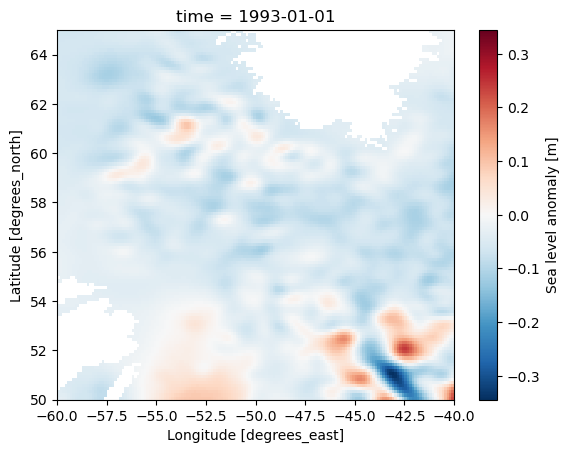

In [11]:
ssh_1993.sla.isel(time=0).plot();

In [14]:
# open ctd data from WOCE line AR7W from 1993
ar7w_1993_ds = xr.open_dataset('/Users/mzahn/data/Labrador_AR7W/cchdo_AR07W/3_18HU93019_1_ctd.nc')

In [16]:
ar7w_1993_ds.station.values

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26'], dtype=object)

In [18]:
ar7w_1993_ds.time.values

array(['1993-06-19T13:08:00.000000000', '1993-06-19T15:27:00.000000000',
       '1993-06-19T16:34:00.000000000', '1993-06-19T18:11:00.000000000',
       '1993-06-19T20:19:00.000000000', '1993-06-19T22:30:00.000000000',
       '1993-06-20T00:39:00.000000000', '1993-06-20T05:15:00.000000000',
       '1993-06-20T07:27:00.000000000', '1993-06-20T10:37:00.000000000',
       '1993-06-20T13:49:00.000000000', '1993-06-20T17:35:00.000000000',
       '1993-06-20T21:53:00.000000000', '1993-06-21T01:52:00.000000000',
       '1993-06-21T06:42:00.000000000', '1993-06-21T13:13:00.000000000',
       '1993-06-21T18:24:00.000000000', '1993-06-21T23:42:00.000000000',
       '1993-06-22T05:16:00.000000000', '1993-06-22T11:03:00.000000000',
       '1993-06-22T18:47:00.000000000', '1993-06-22T23:48:00.000000000',
       '1993-06-23T04:44:00.000000000', '1993-06-23T08:53:00.000000000',
       '1993-06-23T12:40:00.000000000', '1993-06-23T16:05:00.000000000',
       '1993-06-23T20:25:00.000000000'], dtype='dat

In [20]:
ssh_1993_day = ssh_1993.sla.sel(time='1993-06-21') # midpoint in CTD profile sampling period

### Open WOD profiles

In [23]:
osd_ds = xr.open_mfdataset('/Users/mzahn/data/Labrador_AR7W/ocldb1769457252.646961.OSD/ocldb1769457252.646961.OSD.nc')
ctd_ds = xr.open_mfdataset('/Users/mzahn/data/Labrador_AR7W/ocldb1769457252.646961.CTD/ocldb1769457252.646961.CTD.nc')

In [25]:
osd_ds = osd_ds.swap_dims({'casts':'time'})
ctd_ds = ctd_ds.swap_dims({'casts':'time'})

In [27]:
# select 2024
osd_2024 = osd_ds.sel(time='2024') # none from 2024
ctd_2024 = ctd_ds.sel(time='2024')

In [29]:
ctd_2024.time.values

array(['2024-05-31T00:56:15.000000512', '2024-05-31T06:56:15.000000512',
       '2024-05-31T13:18:44.999999488', '2024-05-31T19:18:44.999999488',
       '2024-05-31T23:48:44.999999488', '2024-06-01T05:37:30.000000000',
       '2024-06-01T09:22:30.000000000', '2024-06-01T15:33:44.999999488',
       '2024-06-01T19:41:15.000000512', '2024-06-02T00:56:15.000000512',
       '2024-06-02T04:41:15.000000512', '2024-06-02T09:56:15.000000512',
       '2024-06-02T14:03:44.999999488', '2024-06-02T18:45:00.000000000',
       '2024-06-02T22:07:30.000000000', '2024-06-03T02:26:15.000000512',
       '2024-06-03T06:56:15.000000512', '2024-06-03T09:33:44.999999488',
       '2024-06-03T14:37:30.000000000', '2024-06-03T15:45:00.000000000',
       '2024-06-03T18:33:44.999999488', '2024-06-03T21:22:30.000000000',
       '2024-06-04T00:45:00.000000000', '2024-06-04T04:52:30.000000000',
       '2024-06-04T07:52:30.000000000', '2024-06-04T15:33:44.999999488',
       '2024-06-04T21:45:00.000000000', '2024-06-05

In [31]:
ssh_2024_day = ssh_2024.sla.sel(time='2024-06-12') # midpoint in CTD profile sampling period

### Plot

/Users/mzahn/miniforge3/envs/sassie/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)


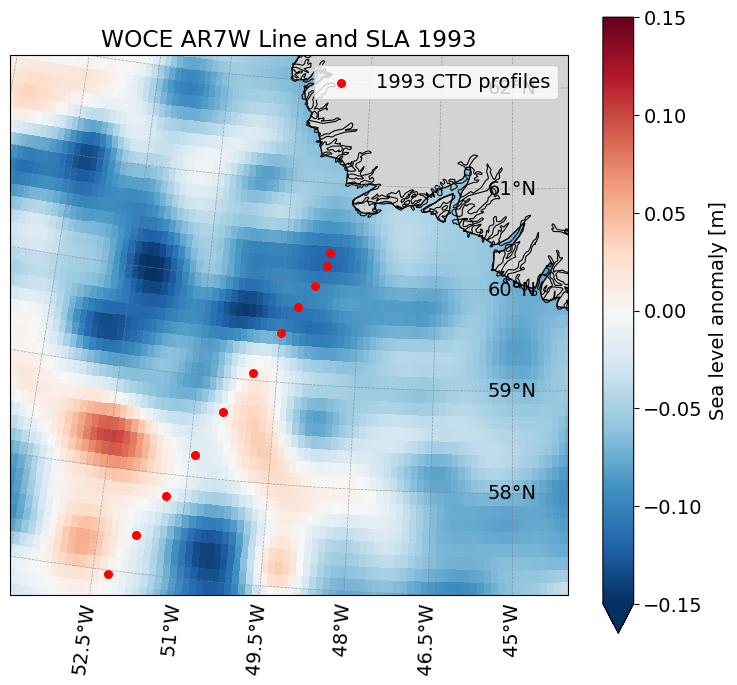

In [47]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))

# Add map features
# ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='lightgray'))
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

# Set extent: focus on high northern latitudes (e.g., above 50N)
ax.set_extent([-54, -44, 57, 62], crs=ccrs.PlateCarree())

# plot ssh
ssh_1993_day.plot(vmin=-0.15,vmax=0.15,cmap='RdBu_r',transform=ccrs.PlateCarree())

# Plot points for 1993
ar7w_1993_ds.plot.scatter(
    x='longitude',
    y='latitude',
    ax=ax,
    color='red',
    s=30,
    transform=ccrs.PlateCarree(),
    label='1993 CTD profiles'
)

# # Plot points for 2024
# ax.scatter(
#     ctd_2024.lon.values,
#     ctd_2024.lat.values,
#     s=30,
#     color="k", marker='x',
#     transform=ccrs.PlateCarree())

# Title and legend
plt.title("WOCE AR7W Line and SLA 1993")
plt.legend()
plt.show()

### With 2024 plotted

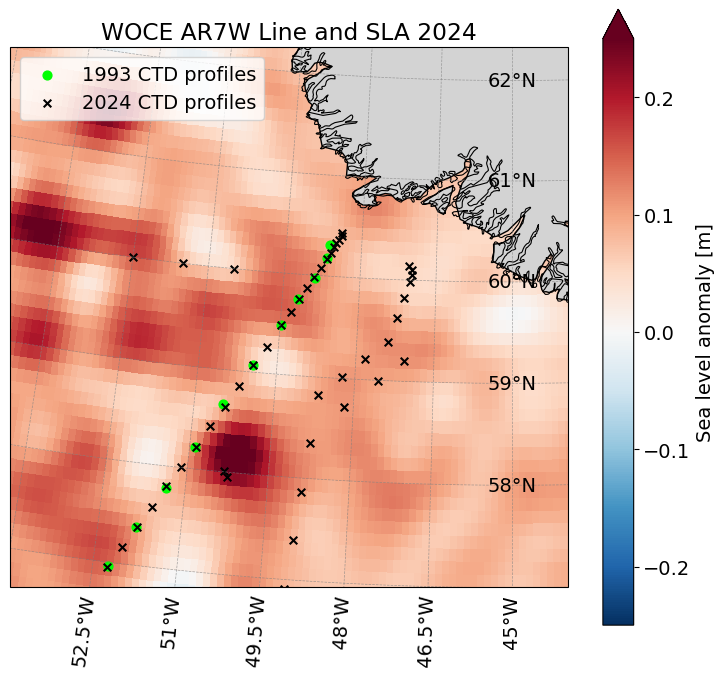

In [69]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))

# Add map features
# ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='lightgray'))
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

# Set extent: focus on high northern latitudes (e.g., above 50N)
ax.set_extent([-54, -44, 57, 62], crs=ccrs.PlateCarree())

# plot ssh
ssh_2024_day.plot(vmin=-0.25,vmax=0.25,cmap='RdBu_r',transform=ccrs.PlateCarree())

# Plot points for 1993
ar7w_1993_ds.plot.scatter(
    x='longitude',
    y='latitude',
    ax=ax,
    color='lime',
    s=40,
    transform=ccrs.PlateCarree(),
    label='1993 CTD profiles'
)

# Plot points for 2024
ax.scatter(
    ctd_2024.lon.values,
    ctd_2024.lat.values,
    s=30,
    color="k", marker='x',
    transform=ccrs.PlateCarree(),
    label='2024 CTD profiles')

# Title and legend
plt.title("WOCE AR7W Line and SLA 2024")
plt.legend(loc='upper left')
plt.show()